In [90]:

import pymdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import copy
import random


# Simulation Settings

In [91]:
#sim settings
tumor_increase_prob = 0.3
resistance_increase_prob = 0.5 
treatment_effect_probs = [1, .8, .6, .5, .4, .2]
resistance_decrease_probs = [.0, .2, .4, .7, .8, .9]
tumor_starting_state = 0 
resistance_starting_state = 0
treatment_starting_state = 0
max_timesteps = 200
noise_sd = 0

## bunch of things used in MDP, could possibly be removed
#define names tumor names
tumor_names = ['t1', 't2', 't3', 't4', 't5', 't6']

#the same for resistances
resistance_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6']

#treatment names
treatment_names = ['no treatment', 'treatment']

#define the state factor array 
num_states = [len(tumor_names), len(resistance_names), len(treatment_names)]
num_factors = len(num_states)

#no possible action for tumor and resistance factor
tumor_action_names = ['Do nothing']
resistance_action_names = ['Do nothing']

#can decide to treat or not
treatment_action_names = ['dont treat', 'treat']
                      
#Define number of control states
num_controls = [len(tumor_action_names), len(resistance_action_names), len(treatment_action_names)]

#Define observation states 
tumor_observation_names = tumor_names
treatment_observation_names = treatment_names

#only tumor level is and treatment are observable, but others could be added.
num_observations = [len(tumor_observation_names), len(treatment_observation_names)]

num_modalities = len(num_observations)

# Define Helper functions
## Plotting functions

In [92]:

def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

#make a functio that generates
def plot_simulation_outcome(df):
        #plot the tumor state and resistance state
        plt.plot(df['tumor_state'], label = 'Tumor level')
        plt.plot(df['resistance_state'], label = 'Resistance level', linestyle = '--')

        #shade in when treatment is on
        for i in range(len(df)):
            if df['treatment_state'][i] == 'treat':
                plt.fill_between(x = [i, i+1], y1 = 0, y2 = 6, color = 'gray', alpha = 0.5)

        #show the labels
        plt.legend()
        plt.show()


## Changed functions
get_exepected-states now works with B-tensors of more dimensions if you tell it how to collapse it. 

two other functions to generate lists of "coin-flips" with different probabilities. This is done to provide a random env, each time, but to make sure that comparing multiple strategies can be done on the same outcomes of the flips.



In [93]:
#collapse tumor by resistance, t-1 beliefs
collapse_list_tumor = [(1, -1)]

#collapse resistance by tumor, t0 beliefs
collapse_list_resistance = [(0, 0)]

#make a list of collapsing workflows ordered by factor
collapse_list = [collapse_list_tumor, collapse_list_resistance, []]

def get_expected_states(qs, B, policy):
    """
    Compute the expected states under a policy, also known as the posterior predictive density over states

    Parameters
    ----------
    qs: ``numpy.ndarray`` of dtype object
        Marginal posterior beliefs over hidden states at a given timepoint.
    B: ``numpy.ndarray`` of dtype object
        Dynamics likelihood mapping or 'transition model', mapping from hidden states at ``t`` to hidden states at ``t+1``, given some control state ``u``.
        Each element ``B[f]`` of this object array stores a 3-D tensor for hidden state factor ``f``, whose entries ``B[f][s, v, u]`` store the probability
        of hidden state level ``s`` at the current time, given hidden state level ``v`` and action ``u`` at the previous time.
    policy: 2D ``numpy.ndarray``
        Array that stores actions entailed by a policy over time. Shape is ``(num_timesteps, num_factors)`` where ``num_timesteps`` is the temporal
        depth of the policy and ``num_factors`` is the number of control factors.

    Returns
    -------
    qs_pi: ``list`` of ``numpy.ndarray`` of dtype object
        Predictive posterior beliefs over hidden states expected under the policy, where ``qs_pi[t]`` stores the beliefs about
        hidden states expected under the policy at time ``t``
    """
    n_steps = policy.shape[0]
    n_factors = policy.shape[1]

    # initialise posterior predictive density as a list of beliefs over time, including current posterior beliefs about hidden states as the first element
    qs_pi = [qs] + [pymdp.utils.obj_array(n_factors) for t in range(n_steps)]
    
    # get expected states over time
    for t in range(n_steps):

        for control_factor, action in enumerate(policy[t,:]):
            
            #figure out which B matrix to use
            collapse_workflows = collapse_list[control_factor]
            
            #Get all slices for the chosen action
            B_factor = B[control_factor][...,int(action)]
            if len(collapse_workflows) > 0:

                #for each collapse which is a (factor and timeoffset), 
                for workflow in collapse_workflows:
                    #get timesteps of belief and what state to collapse by
                    factor, time_offset = workflow

                    #Get the dot.product to collapse the b
                    B_factor = B_factor.dot(qs_pi[t+time_offset+1][factor])

            #calculate expected posterior of the state for the timestep given the action
            qs_pi[t+1][control_factor] = B_factor.dot(qs_pi[t][control_factor])

    #Return a list of expected states given the policy
    return qs_pi[1:]

#Put the function in control, so it works for down-stream functions
pymdp.control.get_expected_states = get_expected_states

#define a function to return a series of coinflips given p and length. Returns an arrays of outcomes
def coinflip(p, length):
    return np.random.binomial(1, p, length)

#def a function to make a list of coinflips given a list of probabilities
def make_coinflips(p_list, length):
    return [coinflip(p, length) for p in p_list]

p_lists = [[tumor_increase_prob], [resistance_increase_prob], treatment_effect_probs, resistance_decrease_probs]

#def a function to add noise to the observation
def add_noise(o, noise_sd):
    o = (round(o[0] + np.random.normal(0, noise_sd)), o[1])
    if o[0] < 0:
        o = (0, o[1])
    elif o[0] > len(tumor_names) - 1:
        o = (5, o[1])

    return o

# Enivorement class
Setting up the env class

In [94]:
class DiscreteTumorEnvFlips():

    #initialize the class, to set startint state to tuple (0,0)
    def __init__(self, tumor_starting_state = tumor_starting_state, resistance_starting_state = resistance_starting_state, treatment_starting_state = treatment_starting_state, tumor_increase_prob = tumor_increase_prob, resistance_increase_prob = resistance_increase_prob, treatment_effect_probs = treatment_effect_probs, resistance_decrease_probs = resistance_decrease_probs):
        
        #simulation parameters
        self.tumor_increase_prob = tumor_increase_prob
        self.resistance_increase_prob = resistance_increase_prob
        self.treatment_effect_probs = treatment_effect_probs
        self.resistance_decrease_prob = resistance_decrease_probs

        #set the starting state for each factor
        self.init_tumor_state = tumor_starting_state
        self.init_resistance_state = resistance_starting_state
        self.init_treatment_state = treatment_starting_state

        #set the current state to the starting state
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #make tumor flips and counter
        self.tumor_increase_flips = make_coinflips([tumor_increase_prob], max_timesteps)
        self.tumor_increase_flip_counter = 0

        #make resistance and counter
        self.resistance_increase_flips = make_coinflips([resistance_increase_prob], max_timesteps)
        self.resistance_increase_flip_counter = 0

        #make treatmeant success flips and a counter for each resistance level
        self.treatment_effect_flips = make_coinflips(treatment_effect_probs, max_timesteps)
        self.treatment_effect_flip_counters = [0] * len(treatment_effect_probs)

        #make resistance decrease flips and a counter for each tumor level
        self.resistance_decrease_flips = make_coinflips(resistance_decrease_probs, max_timesteps)
        self.resistance_decrease_flip_counters = [0] * len(tumor_names)
        #print(f'Starting tumor state is {tumor_starting_state}, starting resistance state is {resistance_starting_state}, starting treatment state is {treatment_starting_state}')
    

    #Define funciton update enviroment
    def step(self, action_label):
        
        #flip to increase tumor burden
        if self.current_tumor_state < len(tumor_names) - 1:
            self.current_tumor_state += self.tumor_increase_flips[0][self.tumor_increase_flip_counter]
            self.tumor_increase_flip_counter += 1
        
        self.current_treatment_state = 0
  
        #if treatment is on take the next treatment flip
        if action_label == "treat":

            self.current_treatment_state = 1

            if self.current_resistance_state < len(resistance_names) - 1:
                self.current_resistance_state += self.resistance_increase_flips[0][self.resistance_increase_flip_counter]
                self.resistance_increase_flip_counter += 1

            #if tumor is at a level above 0, reduce it by the treatment effect probability
            if self.current_tumor_state > 0:
                self.current_tumor_state -= self.treatment_effect_flips[self.current_resistance_state][ self.treatment_effect_flip_counters[self.current_resistance_state]]
                self.treatment_effect_flip_counters[self.current_resistance_state] += 1
            
        elif self.current_resistance_state > 0:
            self.current_resistance_state -= self.resistance_decrease_flips[self.current_tumor_state][self.resistance_decrease_flip_counters[self.current_tumor_state]]
            self.resistance_decrease_flip_counters[self.current_tumor_state] += 1
        

        #make for the other envs to
        return self.current_tumor_state, self.current_resistance_state, self.current_treatment_state
    
    def reset(self):
        #reset states to initial states
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #print that the states have been reset
        #print(f'Starting tumor state is {self.current_tumor_state}, starting resistance state is {self.current_resistance_state}, starting treatment state is {self.current_treatment_state}')


env = DiscreteTumorEnvFlips()    

# Setup generative model
## Likelihood models - A matricies

Simulate noised observations to code likelihood matrix

In [95]:
int_list = []
noise_list = []
for i in range(100000):
    integer = random.choice(range(len(tumor_names)))

    o = (integer, 0)

    o = add_noise(o, noise_sd)

    int_list.append(integer)

    noise_list.append(o[0])

noise_df = pd.DataFrame({'int': int_list, 'noise': noise_list})


Use them to infer observations

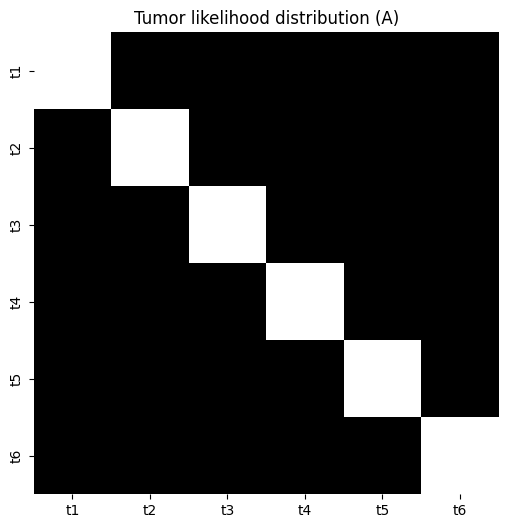

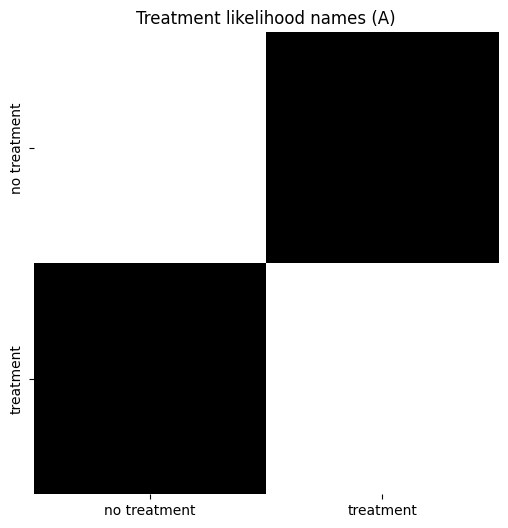

In [96]:
#Create A likelihood matrix per modality. Since there are only two observable outcomes, tumor level and treatment, there will be two likelihood arrays
#Create an empty array to store the likelihoods
A = pymdp.utils.obj_array( num_modalities )

#Create a likelihood matrix for the tumor modality
A_tumor = np.zeros((len(tumor_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))
                   
#Fill in the likelihood matrix for the tumor modality, with perfect observation of the tumor level
for i in range(len(tumor_observation_names)):
    for j in range(len(tumor_names)):     
        #if on the diagonal, the observation is correct
            A_tumor[i, j, :, :] = sum(noise_df[noise_df['int'] == j]['noise'] == i) / len(noise_df[noise_df['int'] == j])

#Store the likelihood matrix for the tumor modality in the likelihood array
A[0] = A_tumor

#Create a likelihood matrix for the treatment modality
A_treatment = np.zeros((len(treatment_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#Fill in the likelihood matrix for the treatment modality, with perfect observation of the treatment
for i in range(len(treatment_observation_names)):
    for j in range(len(treatment_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_treatment[i, :, :, j] = 1.0

#Store the likelihood matrix for the treatment modality in the likelihood array
A[1] = A_treatment


#Plot the likelihood matrix for the tumor modality to check. Pick the first state of the resistance factor and no treatment
plot_likelihood(A_tumor[:, :, 0, 0], xlabels = tumor_names, ylabels = tumor_observation_names, title_str = "Tumor likelihood distribution (A)")

#For treatments
plot_likelihood(A_treatment[:, 1, 2, :], xlabels = treatment_names, ylabels = treatment_observation_names, title_str = "Treatment likelihood names (A)")

## Transition probabilities - B matricies
Make a transition probability matrix for each state factor. Means that $B[0]$ correpsonds to tumor transition probabilities, and that $B[1]$ to resistance transition probabilties.

In [97]:
#Set the number of sub-arrays equal to number of factors
B = pymdp.utils.obj_array(num_factors) 

#Create B_tumor for tumor factor
B_tumor = np.zeros( (len(tumor_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#fill in no treatment cancer progression. 
#rows correspond to the next state, columns to the current state. If treatment equals no treatment, the risk of tumor progression is simply the risk of tumor progression. #iterate through all resistance states and set one below the diagonal to the risk of tumor progression
for i in range(len(resistance_names)):

    #fill the diagonal with 1 - tumor_increase_prob
    np.fill_diagonal(B_tumor[:, :, i, 0], 1 - tumor_increase_prob)

    #fill the one below the diagonal with tumor_increase_prob
    np.fill_diagonal(B_tumor[1:, :, i, 0], tumor_increase_prob)

    #if tumor is at the top level, it can't increase anymore
    B_tumor[-1, 5, i, 0] = 1.0


#fill in treatment cancer progression. during treatment the chance of tumor progression depends on the resistance level.
for i in range(len(resistance_names)):

    #find the chance of treatment working given the resistance level
    treatment_succeeds = treatment_effect_probs[i]

    #the chance of reduction is the both the chance of progression doesn't happen and that treatment succeeds
    chance_of_reduction = treatment_succeeds * (1 - tumor_increase_prob)

    #chance of no reduction is the chance of progression happening and treatment succeding or treatment failing and progression not happening
    chance_of_no_change =  treatment_succeeds * tumor_increase_prob + (1 - treatment_succeeds) * (1 - tumor_increase_prob)

    #chance of increase in tumor is the chance of treatment failing and progression happening
    chance_of_increase = (1 - treatment_succeeds) * tumor_increase_prob

    #fill in transition probs for treatment working given the resistance level
    np.fill_diagonal(B_tumor[:, 1:, i, 1], chance_of_reduction)
    np.fill_diagonal(B_tumor[:, :, i, 1], chance_of_no_change)
    np.fill_diagonal(B_tumor[1:, :, i, 1], chance_of_increase)

    #if the tumor is at minimal state, it treatment isn't applied and it therefore can't be reduced any more. The chance of staying is therefore whatever is left after the risk of increasing and treatment failing. This is equal to tumor not progressing or tumor progressing and treatment working.
    B_tumor[0,0,i,1] = 1 - chance_of_increase

    #if the tumor is at maximal state, it can't increase anymore, the chance of staying is therefore everything except for reduction
    B_tumor[-1, -1, i, 1] = 1 - chance_of_reduction

#initialize the B_treatment matrix
B_resistance = np.zeros((len(resistance_names), len(resistance_names), len(tumor_names), len(treatment_names)))


#fill in no treatment resistance progression. Diagonal is chance of resistance not increasing, one below diagonal is chance of resistance increasing, and one above diaganol is chance of resistance decreasing
for i in range(len(tumor_names)):

    #Find the chance of resistance decreasing given the tumor level
    resistance_decrease_prob = resistance_decrease_probs[i]

    #chance of reducing the resistance level depends on the tumor level
    chance_of_reduction_no_treatment = resistance_decrease_prob

    #Probability of of no change can only happen if the resistance isn't reduced when treatment isn't given. 
    chance_of_no_change_no_treatment = 1 - chance_of_reduction_no_treatment

    #fill in transition probs for no treatment
    np.fill_diagonal(B_resistance[:, 1:, i, 0], chance_of_reduction_no_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 0], chance_of_no_change_no_treatment)

    #when treatment is off and resistance is at lowest level, resistance can't decrease anymore
    B_resistance[0, 0, i, 0] = 1.0

    #The risk of progressing in resistance
    chance_of_increase_treatment = resistance_increase_prob

    #chance of reduction is the chance of resistance not increasing
    chance_of_no_change_treatment = (1 - resistance_increase_prob)

    #fill in transition probs for treatment
    #np.fill_diagonal(B_resistance[:, 1:, i, 1], chance_of_reduction_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 1], chance_of_no_change_treatment)
    np.fill_diagonal(B_resistance[1:, :, i, 1], chance_of_increase_treatment)

    #when treatment is on and resistance is at its highest level, resistance can't increase anymore, instead it just stays at same level since treatment is applied
    B_resistance[-1, -1, i, 1] = 1.0


#fill in TPMs for deciding to treat. This always is perfect probability of choosing the treatment transitions into treatment
B_treatment = np.zeros((len(treatment_names), len(treatment_names), len(treatment_action_names)))

#setup matrix for controlling treatment. Treatment is always perfectly applied
for i in range(len(treatment_names)):
    B_treatment[i,:,i] = 1 

#save the matricies to the B array
B[0] = B_tumor
B[1] = B_resistance
B[2] = B_treatment


## Setup prior beliefs - D-vectors
Could probably be varied over different for different states. Doesn't currently correspond to starting state

In [98]:
D = pymdp.utils.obj_array(num_factors)

#set perfect knowledge for tumor
D_tumor = np.zeros((len(tumor_names)))
D_tumor[:] =  1/len(tumor_names)

#set uniform dist over resistance
D_resistance = np.zeros((len(resistance_names)))
D_resistance[:] = 1/len(resistance_names)

#set perfect knowledge for treatment
D_treatment = np.zeros((len(treatment_names)))
D_treatment[:] = 1/len(treatment_names)

D[0] = D_tumor
D[1] = D_resistance
D[2] = D_treatment


## Prior preferences. Setting up a C-matrix
### Random simulation
This is done in order to select the best performing runs to fit behavior to.

In [99]:
##sim params: number of sims, max length of sims
def simulate_random_therapy(num_sims = 10, max_steps = 100):

    #initialize the list of dataframes to store the states for each env
    dfs = []

    #run the simulation for the number of simulations
    for i in range(num_sims):

        #reset the environment
        env = DiscreteTumorEnvFlips()

        #make an empty list of dictionaries to store the states
        dicts = []

        #initialize the adaptive strategy
        doing, not_doing = "treat", "not treating"

        tumor_state = 0

        #run the simulation loop
        for i in range(max_steps):

            #if the tumor state is at the highest level, break the loop
            if tumor_state == 5:
                break

            #take a step in the environment
            tumor_state, resistance_state, treatment_state = env.step(doing)

            #take a 10% guess to switch action or not
            if np.random.binomial(1, 0.1):
                doing, not_doing = not_doing, doing


            #store states in a dictionary
            state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': doing}

            #append the dictionary to the list of dictionaries
            dicts.append(state_dict)

        #convert the list of dictionaries to a pandas dataframe
        df = pd.DataFrame(dicts)

        #append the dataframe to the list of dataframes
        dfs.append(df)

    #return the list of dataframes
    return dfs

#run the simulation
dfs = simulate_random_therapy(num_sims = 1000, max_steps = max_timesteps)

#count up the number times each tumor state is reached
tumor_state_counts = np.zeros(6)

#iterate through the dataframes, and count how many times a state was visited
for df in dfs:

    #get value counts
    current_count = df['tumor_state'].value_counts()

    if len(current_count) < 6:
        current_count = current_count.reindex(range(6), fill_value = 0)
        new_count = tumor_state_counts + current_count
 

    tumor_state_counts += current_count

#if there are NAs because state wasn't visisted then set the count to zero for the trial.
tumor_state_counts = tumor_state_counts.fillna(0)

### Set prior preferences using the data on the random treatments
Currently each count is scaled by the total number of counts. Would it be better to just use the raw counts?


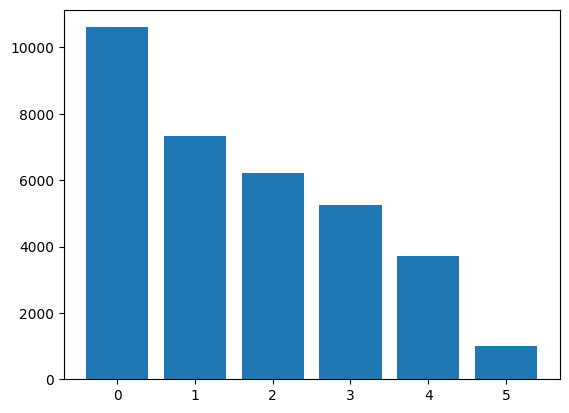

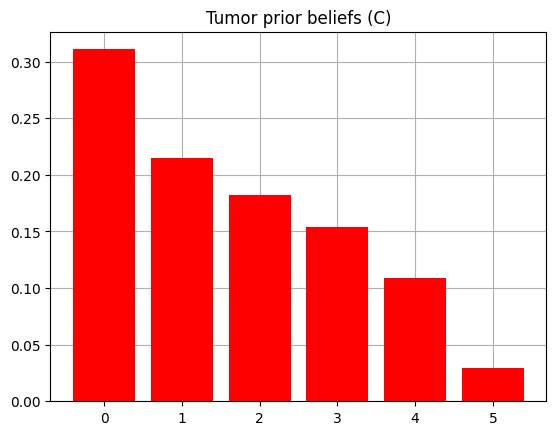

In [100]:

#make as many c-array as there are modalities
C = pymdp.utils.obj_array(num_modalities)

#make a prior belief for the tumor state
C_tumor = np.zeros(len(tumor_names))

#Get the state and count for that value
for value, count in tumor_state_counts.items():
    
    #assign the value to the correct slot in C_tumor
    C_tumor[value] = count / sum(tumor_state_counts.values)

#store the prior belief in the first slot C array so that it matches the overall structure of the POMDP
C[0] = C_tumor

#Make another prior belief for the treatment modality, since all modalities need a prior preference
C_treatment = np.zeros(len(treatment_names))

#store in the second slot, since it is the second modality
C[1] = C_treatment


#plot a histogram of the tumor state counts
plt.bar(tumor_state_counts.index, tumor_state_counts.values)
plt.show()

#plot the prior beliefs, just to see it mathces
plot_beliefs(C_tumor, title_str = "Tumor prior beliefs (C)")




# Compare the POMDP to an implemenation of Adaptive Therapy


## Plotting and analysis of results.
Could perhaps be moved to otherfile


In [101]:
### OVERIDES C dist ## 

C[0] = np.zeros(len(tumor_names))
C[0][-1] = -100


## sim params: number of sims, max length of sims
def simulate_comparison(num_sims = 10, max_steps = 100):


    #initialize the list of dataframes to store the states for each env
    dfs_env1 = []
    dfs_env2 = []

    #make a list of policies
    base_policies = [np.zeros((3,3)), np.ones((3,3))]
    policies = []

    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    policies.append(np.vstack((base_policies[i], base_policies[j], base_policies[k], base_policies[l])))


    agent = pymdp.agent.Agent(A = A, B = B, C = C, D = D, num_controls =[2,2,2], policies=policies, inference_horizon=40, sampling_mode="full")

    #run the simulation for the number of simulations
    for i in range(num_sims):

        #generate a list of noise for tumor obs
        noise = np.random.normal(loc = 0, scale = noise_sd, size = max_steps)

        #reset the environment
        env1 = DiscreteTumorEnvFlips()  
        env2 = copy.deepcopy(env1)

        #make an empty list of dictionaries to store the states
        dicts1 = []
        agent_dicts = []

        #initialize the adaptive strategy
        adaptive_strategy = "Dont treat"

        tumor_state = 0

        #run the simulation loop for ADT i.e. env1 
        for j in range(max_steps):

            #if the tumor state is at the highest level, break the loop
            if tumor_state == len(tumor_names) - 1:
                break
            
            #take a step in the environment
            tumor_state, resistance_state, treatment_state = env1.step(adaptive_strategy)

            #add noise to the observation
            observed_tumor_state = round(noise[j] + tumor_state)
            
            #make sure it is within bounds of the tumor state
            if observed_tumor_state < 0:
                observed_tumor_state = 0
            elif observed_tumor_state > len(tumor_names) - 1:
                observed_tumor_state = 5

            #when tumor level hits 4, begin treatment
            if observed_tumor_state > 3:
                adaptive_strategy = treatment_action_names[1]

            #when it comes below 1, stop treatment
            if observed_tumor_state < 2:
                adaptive_strategy = treatment_action_names[0]

            #store states in a dictionary
            state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': adaptive_strategy}

            #append the dictionary to the list of dictionaries
            dicts1.append(state_dict)

        #convert the list of dictionaries to a pandas dataframe
        df1 = pd.DataFrame(dicts1)

        #append the dataframe to the list of dataframes
        dfs_env1.append(df1)

        ### ENV 2 ### setup agent
        #setup enviroment
        tumor_state, resistance_state, treatment_state = 0,0,0

        action_idx = 0
        action = treatment_action_names[action_idx]

        agent.reset()

        #run the simulation loop for env 2
        for j in range(max_steps):

            if tumor_state == 5:
                break

            #read values from env
            tumor_state, resistance_state, treatment_state = env2.step(action)

            #add noise to the observation
            observed_tumor_state = round(noise[j] + tumor_state)
            
            #make sure it is within bounds of the tumor state
            if observed_tumor_state < 0:
                observed_tumor_state = 0
            elif observed_tumor_state > len(tumor_names) - 1:
                observed_tumor_state = 5

            #set observation to tumor state, and current treatment
            o = (observed_tumor_state, treatment_state)

            qs = agent.infer_states(o)

            #do whatever infer_policies does
            q_pi, EFE = agent.infer_policies()

            agent.get_future_qs()

            #sample and action
            sampled_action  = agent.sample_action()
            
            #set the action from last round
            action = treatment_action_names[action_idx]

            #store info
            state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': action, 'tumor_beliefs': qs[0], 'resistance_beliefs': qs[1], 'treatment_beliefs': qs[2]}

            #comvert to index to use in setting action of next round
            action_idx = int(sampled_action[2])
            
            #append the dictionary to the list of dictionaries
            agent_dicts.append(state_dict)

        #convert the list of dictionaries to a pandas dataframe
        df2 = pd.DataFrame(agent_dicts)

        #append the dataframe to the list of dataframes
        dfs_env2.append(df2)

         #print the simulation number
        print(f'Simulation {i + 1} out of {num_sims} completed.')
    
    #return the list of dataframes
    return dfs_env1, dfs_env2


#run the simulation and store results in the lists of data frames ## takes 8 hours to run 80 sims
dfs1, dfs2 = simulate_comparison(num_sims = 100, max_steps = max_timesteps)

KeyboardInterrupt: 

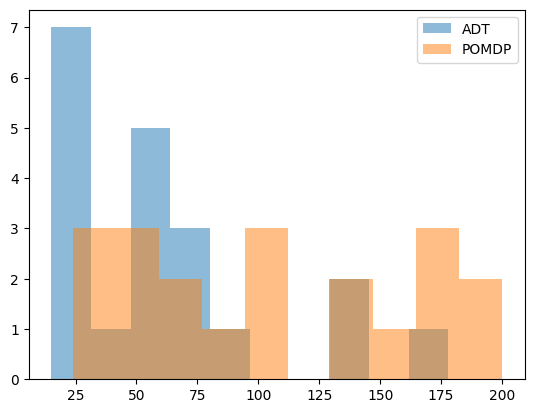

ADT mean length is 62.0, POMDP mean length is 105.6


In [ ]:
#count up the lengths of each simulation
sim_lengths_adt = []
sim_lengths_POM = []

for df in dfs1:
    sim_lengths_adt.append(len(df))

for df in dfs2:
    sim_lengths_POM.append(len(df))

#make a df combining the both sim_lengths
df_lengths = pd.DataFrame({'ADT': sim_lengths_adt, 'POMDP': sim_lengths_POM})

#write it to a csv in the simulated data folder
df_lengths.to_csv('simulated_data/sim_lengths.csv')

#plot the histogram of the lengths of each simulation
plt.hist(sim_lengths_adt, alpha = 0.5, label = 'ADT')
plt.hist(sim_lengths_POM, alpha = 0.5, label = 'POMDP')
plt.legend()
plt.show()

print(f'ADT mean length is {np.mean(sim_lengths_adt)}, POMDP mean length is {np.mean(sim_lengths_POM)}')